Дорогой студент!

В данном домашнем задании предоставляется возможность поработать с задачей по распознаванию позитивных и негативных отзывы людей по автомобилю Tesla. База для обучения содержит два текстовых файла с рядом строчных отзывов с мнением людей об автомобиле Tesla, соответственно негативного и позитивного содержания. Ссылка на скачивание базы уже включена в ноутбук задания.


Необходимо выполнить следующие действия:

  1. Загрузите саму базу по ссылке и подговьте файлы базы для обработки.
  2. Создайте обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети в 85-90% на проверочной выборке.
   


**Импорт библиотек, загрузка базы и подготовка её к предобработке.**

In [1]:
# Работа с массивами данных
import numpy as np
# Отрисовка графиков
import matplotlib.pyplot as plt
import tensorflow as tf
# Для работы с файлами в Colaboratory
import os
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
# Заполнение последовательностей до определенной длины
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

%matplotlib inline

In [2]:
# Загрузка датасетов из облака google
import gdown

### Установка сида

In [3]:
SEED = 52
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/tesla.zip', None, quiet=True)

'tesla.zip'

**Деление общей базы отзывов на данные для обучения и проверки.**

In [6]:
# Распаковка архива в папку writers
!unzip -qo tesla.zip -d tesla/

# Просмотр содержимого папки
!ls tesla

'Негативный отзыв.txt'	'Позитивный отзыв.txt'


**Загрузка текста из файлов, преобразование в одну строку.**

In [7]:
# Объявляем функции для чтения файла. На вход отправляем путь к файлу
def read_text(file_name):

  # Задаем открытие нужного файла в режиме чтения
  read_file = open(file_name, 'r')

  # Читаем текст
  text = read_file.read()

  # Переносы строки переводим в пробелы
  text = text.replace("\n", " ")

  # Возвращаем текст файла
  return text

# Объявляем интересующие нас классы
class_names = ["Негативный отзыв", "Позитивный отзыв"]

# Считаем количество классов
num_classes = len(class_names)

### Тексты в один список

In [8]:
import os
# Создаём список под тексты для обучающей выборки
texts_list = []

# Циклом проводим итерацию по текстовым файлам в папке отзывов
for j in os.listdir('/content/tesla/'):

  # Добавляем каждый файл в общий список для выборки
        texts_list.append(read_text('/content/tesla/' + j))

        # Выводим на экран сообщение о добавлении файла
        print(j, 'добавлен в обучающую выборку')

Негативный отзыв.txt добавлен в обучающую выборку
Позитивный отзыв.txt добавлен в обучающую выборку


### Объем текстов

In [9]:
# Узнаем объём каждого текста в словах и символах
texts_len = [len(text) for text in texts_list]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Выводим на экран  информационное сообщение
print(f'Размеры текстов по порядку (в токенах):')

# Циклом проводим итерацию по списку с объёмами текстов
for text_len in texts_len:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста
  print(f'Текст №{t_num}: {text_len}')

Размеры текстов по порядку (в токенах):
Текст №1: 134535
Текст №2: 213381


Далее рассчитаем, сколько символов составит 80% объёма каждого текста, чтобы по полученному индексу отделить эти 80% на обучающую и оставшиеся 20% на проверочную выборку. Эти значения необходимы для подготовки деления на выборки слайсингом по индексу.

In [10]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста
train_len_shares = [(i - round(i/5)) for i in texts_len]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1

  # Выводим на экран сообщение о номере и объёме текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} символов')

Доля 80% от текста №1: 107628 символов
Доля 80% от текста №2: 170705 символов


Импортируем функцию **chain()** для добавления текстов в каждую выборку.

---
 Дополнительная информация: ([База знаний УИИ  - **"Методы работы со списками: функция chain( )**"](https://colab.research.google.com/drive/1KJKg_WYD8Vq63cciOMBEEAhFpyPv0A0V?usp=sharing/))

---

Производём нарезку (метод слайсинга) по полученному ранее индексу для формирования текстов отдельно для обучающей(80%) и проверочной(20%) выборок:

In [11]:
# Создаем список для обучающих и проверочных выборок
train_texts = []
val_texts = []

# Циклом проводим итерацию по списку с текстами и их индексами
for text, train_len_share in zip(texts_list, train_len_shares):
    # Нарезаем тексты на обучающие и проверочные выборки
    train_text = text[:train_len_share]
    val_text = text[train_len_share:]

    # Добавляем тексты в соответствующие списки
    train_texts.append(train_text)
    val_texts.append(val_text)

### Использование токенайзера

In [12]:
maxWordsCount = 15000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(train_texts) # словарь частотности
items = list(tokenizer.word_index.items())

In [13]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(train_texts) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(val_texts)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", train_texts[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:                Водитель наслаждается от такого авто и вождения  Красивая машина нужно брать  Тесла то
Он же в виде последовательности индексов:  [1188, 6611, 27, 270, 23, 2, 811, 201, 14, 80, 273, 9, 443, 6612, 27, 183, 502, 1001, 380, 1122] 



### Подсчет символов выборок

In [14]:
nClasses = len(class_names)
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(class_names[i], " "*(10-len(class_names[i])), len(train_texts[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(train_texts[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(class_names[i], ' '*(10-len(class_names[i])), len(val_texts[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(val_texts[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Негативный отзыв  107628 символов,  16924 слов
Позитивный отзыв  170705 символов,  25769 слов
----
В сумме  278333  символов,  42693  слов 


Статистика по тестовым текстам:
Негативный отзыв  26907 символов,  4330 слов
Позитивный отзыв  42676 символов,  6591 слов
----
В сумме  69583  символов,  10921  слов


### Базовые параметры

In [15]:
# Базовые параметры
xLen = 500 # Длина отрезка текста, по которой анализируем, в словах
step = 400 # Шаг разбиения исходного текста на обучающие векторы
epo = 25 # Число эпох обучения

### Формирование обучающей выборки по листу индексов слов

In [16]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step

  return xSample

In [17]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(class_names)
  classesXSamples = []
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # Формируем один общий xSamples
  xSamples = [] # Список размером "суммарное кол-во окон во всех текстах * длину окна"
  ySamples = [] # Список размером "суммарное кол-во окон во всех текстах * вектор"

  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # По каждому окну
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

### Извлечение выборок
Получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

In [18]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(106, 500)
(106, 2)
(26, 500)
(26, 2)


In [19]:
print(xTrain[0])

[  99 3823    5  582   46 1624  148 3824  244 3825   20 2226  114    4
 3826    6 1260 2227 1261  245  444 3827   11    4   23   21    4 1625
   41 2228   62    6  292   11    4   23    6    4   23   11 1626 3828
  493 3829   21  327 1627 1627 1627    2   89  583    2  155 1262 2229
 2230  494  530 2231  584   93 1628  122 3830  874 1263   29   10 3831
 3832 2232    4   80 1629   51   12 2233 2234 3833    2  149  875 3834
   35   82   12 2235    2  224    4   34 3835 2232   27  293 2235   42
 3836    2 3837  585   44 3838 3839    2  586    5 1630   44 3840 3841
  225 2236   90  128 3842    2 3843   12 3844 3845    4   80 1629   51
   12 2233    9    6  292  107   26  657  268   12   15   40    2 2237
   35 3846 3847  175  531 1631   15  308  587  309 3848    5    4  176
 3849 3850  658   37  876    2 3851    7 3852  532    5 1632  445  114
 3853 1633 3854  763 3855  764    7 1029  139 1264 3856   12 2238 3857
 3858   15  137    4 1030   83  659  310    7   10  588   83 3859   55
   76 

### Токенайзер

In [20]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words

(106, 15000)
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 1.]


In [21]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 

### Создание модели

In [22]:
# Создаём полносвязную сеть
model02 = Sequential()

# Первый полносвязный слой с L2-регуляризацией
model02.add(Dense(100, input_dim=maxWordsCount, activation="sigmoid", kernel_regularizer=l2(0.01)))

# Слой регуляризации Dropout
model02.add(Dropout(0.5))  # Добавляем Dropout с коэффициентом 0.5

# Слой пакетной нормализации
model02.add(BatchNormalization())

# Выходной полносвязный слой с L2-регуляризацией
model02.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))

# Уменьшаем скорость обучения
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model02.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model02.fit(xTrain01,
                      yTrain,
                      epochs=epo,
                      batch_size=128,
                      validation_data=(xTest01, yTest))


Epoch 1/25
1/1 [==============================] - 3s 3s/step - loss: 3.2983 - accuracy: 0.4340 - val_loss: 2.8630 - val_accuracy: 0.3846
Epoch 2/25
1/1 [==============================] - 0s 85ms/step - loss: 2.5290 - accuracy: 0.6887 - val_loss: 2.6141 - val_accuracy: 0.3846
Epoch 3/25
1/1 [==============================] - 0s 71ms/step - loss: 2.0564 - accuracy: 0.8302 - val_loss: 2.3923 - val_accuracy: 0.3846
Epoch 4/25
1/1 [==============================] - 0s 76ms/step - loss: 1.8667 - accuracy: 0.8396 - val_loss: 2.1934 - val_accuracy: 0.3846
Epoch 5/25
1/1 [==============================] - 0s 75ms/step - loss: 1.5446 - accuracy: 0.9623 - val_loss: 2.0154 - val_accuracy: 0.3846
Epoch 6/25
1/1 [==============================] - 0s 73ms/step - loss: 1.3967 - accuracy: 0.9811 - val_loss: 1.8537 - val_accuracy: 0.4615
Epoch 7/25
1/1 [==============================] - 0s 85ms/step - loss: 1.2734 - accuracy: 0.9906 - val_loss: 1.7103 - val_accuracy: 0.5000
Epoch 8/25
1/1 [=============

In [23]:
model02.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               1500100   
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1500702 (5.72 MB)
Trainable params: 1500502 (5.72 MB)
Non-trainable params: 200 (800.00 Byte)
_________________________________________________________________


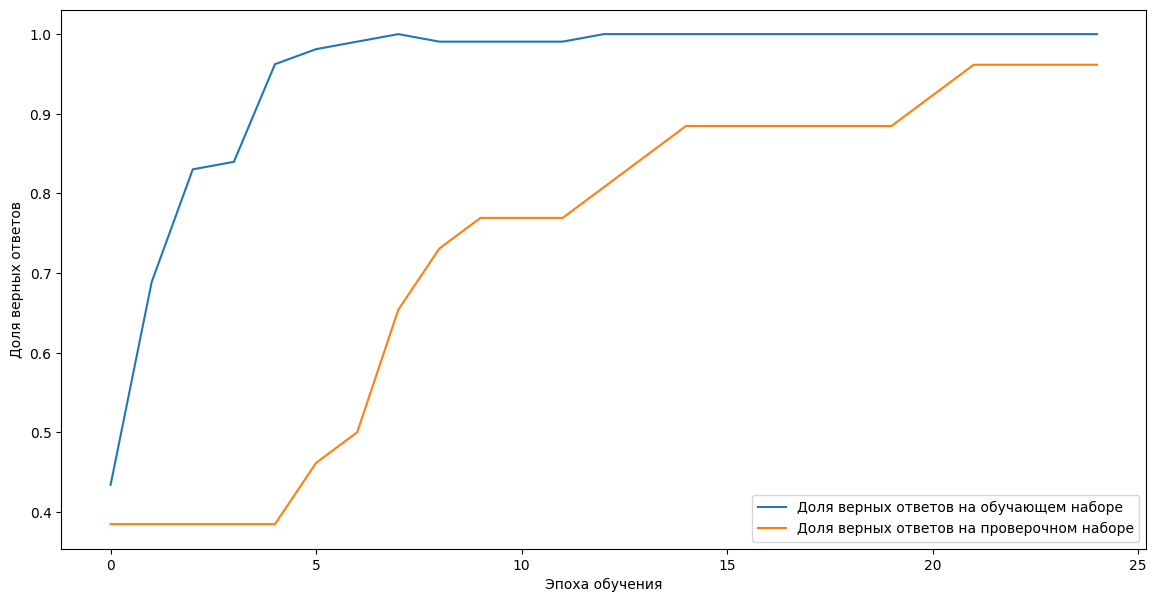

In [24]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()